Name: 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Linear Regression Exercise

This exercise will guide you in implementing the Linear Regression Model to gain intuitions and develop a deeper understanding of the model. These concepts will form as the foundation for more complex models later on.

**You will learn to:**
- Build the general architecture of a Linear Regression Model.
    - Implement the Analytical solution for the parameters that minimizes the loss function
    - Implement the Approximate / Iterative solution for finding the parameters that minimizes the Loss function 
        - Initializing Parameters
        - Calculating the Cost/Loss/Objective Function
        - Computing for the gradients of the Loss function with respect to the parameters
        - Implement gradient descent to update the paramters
        
**General Instructions:**
- You may add your own variables but you may not delete.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math
import os

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Fix the seed of the random number 
# generator so that your results will match ours
np.random.seed(1)

%load_ext autoreload
%autoreload 2

## Dataset
We will use the sales prices of houses in Kansas City as our dataset. It has 21 columns:

1. **id** - (numeric) unique id for each house
2. **date** - (string) Date house was sold
3. **price** - (numeric) Price at which the house was sold
4. **bedrooms** - (numeric) Number of bedrooms
5. **bathrooms** - (numeric) Number of bathrooms  / bedrooms
6. **sqft_living** - (numeric) Square footage of the house
7. **sqft_lot** - (numeric) Square footage of the lot
8. **floors** - (numeric) Total floors (levels) in the house
9. **waterfront** - (numeric) House which has a view to a waterfront
10. **view** - (numeric) Has been viewed (binary)
11. **condition** - (numeric) How good he condition is overall
12. **grade** - (numeric)  Overall grade given to the housing unit, based on King County grading system
13. **sqft_above** - (numeric) Square footage of house apart from basement
14. **sqft_basement** - (numeric) Square footage of the basement
15. **yr_built** - (numeric) Year the house was built
16. **yr_renovated** - (numeric) Year when the house was renovated
17. **zipcode** - (numeric) Zip-code
18. **lat** - (numeric) Latitude coordinate
19. **long** - (numeric) Longitude coordinate
20. **sqft_living15** - (numeric) Living room area in 2015(implies-- some renovations). This might or might not have affected the lotsize area
21. **sqft_lot15** - (numeric) LotSize area in 2015(implies-- some renovations)

In [ ]:
# reads the csv file and converts it into a pandas dataframe
# file_dir = '/content/drive/My Drive/GRAD STUDIES/Term 1 AY 2020-2021/CSC713M Machine Learning/Notebooks/02 - Linear Regression/ME/kc_house_data.csv'
rawData = pd.read_csv('kc_house_data.csv')
rawData = pd.read_csv(file_dir)
print("Shape of the raw data", rawData.shape)

# displays the first 5 entries
rawData.head()

Shape of the raw data (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Our goal is to predict the price of a house using the information available (i.e. all the columns except for the price). For now, we will only use one feature / variable (sqft_living) to be able to visualize the dataset in a 2D plane.

In [ ]:
# common summary statistics
rawData.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
# this gets the columns "sqft living" and "price"
data = rawData[['sqft_living', 'price']]
data.head()

,sqft_living,price
0,1180,221900.0
1,2570,538000.0
2,770,180000.0
3,1960,604000.0
4,1680,510000.0


In [ ]:
# convert the pandas dataframe to numpy array
# data = data.as_matrix() # Deprecated since version 0.23.0
data = data.to_numpy()
data

array([[  1180., 221900.],
       [  2570., 538000.],
       [   770., 180000.],
       ...,
       [  1020., 402101.],
       [  1600., 400000.],
       [  1020., 325000.]])

Now, we will separate our dataset into 2 datasets: the **train** and **test** datasets.

The linear regression model will look for a good set of **weights/theta** after looking at the train dataset. After training, we will confirm with the never-before-trained-on test set and see if the weights we learned will still perform well.

In [ ]:
num_data = data.shape[0]

# Split the dataset into train, val, and test
train_percentage = 0.7
num_train = np.floor(num_data*train_percentage).astype(int)
num_val = (num_data - num_train) // 2
num_test = (num_data - num_train) // 2

# numpy.expand_dims inserts a new axis / dimension. 
# This is makes it more convenient to process later on
# doc url: https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html
X_train = np.expand_dims(data[0:num_train,0], -1)
y_train = np.expand_dims(data[0:num_train,1], -1)

X_val = np.expand_dims(data[num_train:num_train+num_val,0], -1)
y_val = np.expand_dims(data[num_train:num_train+num_val,1], -1)

X_test = np.expand_dims(data[num_train+num_val:num_train+num_val+num_test,0], -1)
y_test = np.expand_dims(data[num_train+num_val:num_train+num_val+num_test,1], -1)

print('Training data shape:',X_train.shape)
print('Training ground truth values shape:',y_train.shape)

print('Validation data shape:',X_val.shape)
print('Validation ground truth values shape:',y_val.shape)

print('Test data shape:',X_test.shape)
print('Test ground truth values shape:',y_test.shape)

Training data shape: (15129, 1)
Training ground truth values shape: (15129, 1)
Validation data shape: (3242, 1)
Validation ground truth values shape: (3242, 1)
Test data shape: (3242, 1)
Test ground truth values shape: (3242, 1)


(0.0, 1500000.0)

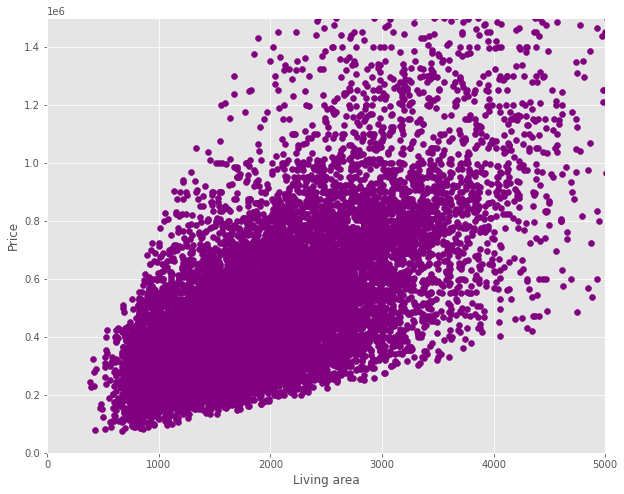

In [ ]:
# plot the data
plt.scatter(X_train,y_train,c='purple')
plt.ylabel("Price")
plt.xlabel("Living area")
plt.xlim([0,5000])
plt.ylim([0,1500000])

From the plot above, we can see the (positive) linear relationship between the living area of the house and its price.

# Linear Regression

## Data Setup
$X \in \mathbb{R}^{N,D}$ - our data is represented as a matrix with $N$ rows and $D$ columns, where each row is a $D$-dimensional feature vector representing an instance / example in our dataset.

$y \in \mathbb{R}^N$ - the prediction target is represented as a vector of length $N$.  


## Method 1: Analytical solution/Closed form/Normal Equation

We can quickly compute for the weights by getting the derivative of our objective function and equating it to 0. However, there are some drawbacks to using this method, as you would see in the following cells.

The next cells show the step-by-step process of implementing the closed form solution of linear regression:
1. Adding $w_0$ in the weight vector $W$ and $x_0$ in $X$ to account for the bias term.
1. Finding for the optimal values of weight vector W using the normal equation.
3. Do some predictions! Now that we have the weights, the label can be solved by plugging in the features $x$ into the linear model. 

### Step 1: Pre-processing! Add in a vector of one to X to account for the bias
This just appends a vector of ones to the dimension of your feature vector to accomodate for the bias / constant term in our hypothesis function.

**Open `linear_regression.py`, and fill in the code for the function `feature_transform`.**

In [ ]:
# os.chdir('')

In [ ]:
# from linear_regression import LinearRegression
from linear_regression import LinearRegression

We will first use a smaller 'dummy' data to make it easier to test and debug your code.

In [ ]:
regressor = LinearRegression()
np.random.seed(1)
dummy_X = np.random.randn(5,3)

# x0 = np.ones((len(dummy_X), 1))
# dummy_transformed_X = np.column_stack([dummy_X, v]) # or np.c_[dummy_X, v] https://stackoverflow.com/questions/20978757/how-to-append-a-vector-to-a-matrix-in-python
        
dummy_transformed_X = regressor.feature_transform(dummy_X)

print("Before feature transform:")
print(dummy_X)
print("Shape:",dummy_X.shape)
print()
print("After feature transform:")
print(dummy_transformed_X)
print("Shape:",dummy_transformed_X.shape)
# print(x0)

Before feature transform:
[[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069   0.3190391 ]
 [-0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944]]
Shape: (5, 3)

After feature transform:
[[ 1.62434536 -0.61175641 -0.52817175  1.        ]
 [-1.07296862  0.86540763 -2.3015387   1.        ]
 [ 1.74481176 -0.7612069   0.3190391   1.        ]
 [-0.24937038  1.46210794 -2.06014071  1.        ]
 [-0.3224172  -0.38405435  1.13376944  1.        ]]
Shape: (5, 4)


**Sanity Check**: 

Expected output of the feature transform function.

Before feature transform:
```
[[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069   0.3190391 ]
 [-0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944]]
Shape: (5, 3)
```
After feature transform:

```
[[ 1.62434536 -0.61175641 -0.52817175  1.        ]
 [-1.07296862  0.86540763 -2.3015387   1.        ]
 [ 1.74481176 -0.7612069   0.3190391   1.        ]
 [-0.24937038  1.46210794 -2.06014071  1.        ]
 [-0.3224172  -0.38405435  1.13376944  1.        ]]
Shape: (5, 4)
```

### Step 2: Train! Compute for the weights via closed form/analytical solution
**In `linear_regression.py`, fill in the code for the function `train_analytic`.**

In [ ]:
np.random.seed(1)
dummy_X = np.random.randn(5,4)
dummy_y = np.random.randn(5,1)
# X = dummy_X
# y = dummy_y
# W = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(y)
# regressor.train_analytic(dummy_X,dummy_y)
X = dummy_X                                
XT = np.transpose(dummy_X)
XTX = np.matmul(XT,X)
XTXT = np.matmul(np.linalg.inv(XTX),XT)
th_normal = np.matmul(XTXT,dummy_y)

print(dummy_X)
print(dummy_y)
print("Weight vector:")
# print(regressor.params['W'])
print(th_normal)

[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387   1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944 -1.09989127]
 [-0.17242821 -0.87785842  0.04221375  0.58281521]]
[[-1.10061918]
 [ 1.14472371]
 [ 0.90159072]
 [ 0.50249434]
 [ 0.90085595]]
Weight vector:
[[-0.70918566]
 [-0.49369412]
 [ 0.39606928]
 [-0.02488702]]


**Sanity Check**: 

Expected weights $W$.

Weight vector:
```
[[ 3.58229626]
 [ 4.10375196]
 [ 4.66577618]
 [ 4.14835304]
 [ 2.50637491]]
```

### Step 3: Test! Predict test data with the weights computed
**In `linear_regression.py`, fill in the code for the function `predict`.**

In [ ]:
np.random.seed(1)
dummy_X = np.random.randn(5,4)
dummy_y = np.random.randn(5,1)
regressor.train_analytic(dummy_X,dummy_y)
predictions = regressor.predict(dummy_X)

print("Input",'\t\t\t\t\t\t\t','Predictions')
for i in range(dummy_X.shape[0]):
    print(dummy_X[i],'\t',predictions[i])

Input 							 Predictions
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862] 	 [-1.03243151]
[ 0.86540763 -2.3015387   1.74481176 -0.7612069 ] 	 [1.23253196]
[ 0.3190391  -0.24937038  1.46210794 -2.06014071] 	 [0.52722154]
[-0.3224172  -0.38405435  1.13376944 -1.09989127] 	 [0.8946833]
[-0.17242821 -0.87785842  0.04221375  0.58281521] 	 [0.55789219]


**Sanity Check**: 

Expected output:

```
Input 							                     Predictions
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862] 	 [-1.10061918]
[ 0.86540763 -2.3015387   1.74481176 -0.7612069 ] 	 [ 1.14472371]
[ 0.3190391  -0.24937038  1.46210794 -2.06014071] 	 [ 0.90159072]
[-0.3224172  -0.38405435  1.13376944 -1.09989127] 	 [ 0.50249434]
[-0.17242821 -0.87785842  0.04221375  0.58281521] 	 [ 0.90085595]
```

### You have now successfully implemented the analytical solution for Linear Regression. Let's try it out on actual (non-dummy) data.

In [ ]:
regressor = LinearRegression()
regressor.train_analytic(X_train,y_train)

print("Weights W:")
print(regressor.params["W"])

Weights W:
[[263.62221]]


### Visualize. It helps to check how our hypothesis "line" looks like plotted with our data. Let's visualize using our weights.

Text(0.5, 0, 'Living area')

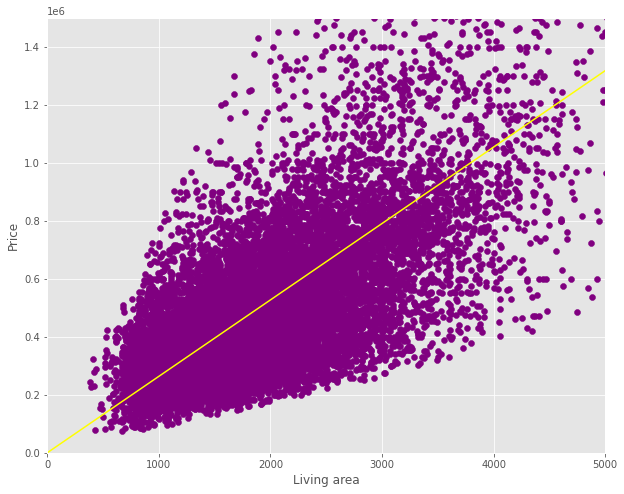

In [ ]:
# plot fitted regression line 
X_range = np.expand_dims(np.arange(0,5000,1),1)
y_range = regressor.predict(X_range)

plt.scatter(X_train,y_train,c='purple')
plt.plot(X_range,y_range,c='yellow')
plt.xlim([0,5000])
plt.ylim([0,1500000])
plt.ylabel("Price")
plt.xlabel("Living area")

If you see a line cutting right across the middle of the green data dots, that's a great sign that our model was able to train properly.

### Let's test it with our own input

The following input will allow us to estimate a price given a living area. 

In [ ]:
print("Type in Q to quit.\n")
while(True):
    print("Living area:")
    a = input()

    if(a == "Q" or a == 'q'):
        break;
    elif(a.isdigit()):
        X_in = np.expand_dims([int(a)],1)
        y_in = regressor.predict(X_in)
        print("For a living area of", a , "sqm, the estimated price is $%0.2f \n" % np.squeeze(y_in))
    else:
        print("Please enter a valid number.")

Type in Q to quit.

Living area:
q


**Try this out.** Try putting in a small number for our square footage. Did you see a negative price? 

Right now, the model predicts negative prices for small inputs. This is because our model does not know that negative prices do not make sense, it will just fit a linear function that extends to the whole range of real numbers including negative numbers. In practice you might want to perform some post processing or some other work arounds to make the predictions more reliable.

### Analytical solution method in a nutshell
The analytical solution / normal equation directly solves for the optimal parameters. This will work well for some problems, but it requires taking the inverse of the matrix $X^TX$. The time complexity of an inverse operation is approximately $O(n^3)$. We also need to store all of our data $X$ in memory to be able to compute for $X^TX$. This makes it impractical to use for very large / high-dimensional datasets. 

Another way to solve for the parameters is using stochastic gradient descent which we will implement next.

## Method 2 : Iterative solution using stochastic gradient descent.

The next cells show the step-by-step process of implementing the stochastic gradient descent solution of linear regression:

1. Adding $w_0$ in the weight vector $W$ and $x_0$ in $X$ to account for the bias term.
2. Initialize the parameters/weight vector $W$
3. Calculate the cost/loss/objective function for the current parameters/weights
4. Compute for the gradients of the loss function with respect to the parameters/weights
5. Update the paramters/weights based on the computed gradients.

Like before, we will first test and debug our code using a smaller dummy dataset.

### Step 1: (Done) Pre-processing! Add in a vector of one to X to account for the bias
We have already implemented this!

### Step 2: Initialize Weights! Initialize the weights to a random value.


**Open `linear_regression.py`, and fill in the code for the function `initialize_weights`.**

In [ ]:
np.random.seed(1)

regressor = LinearRegression()
regressor.initialize_weights(5)
print("Weights vector:")
print(regressor.params["W"])

Weights vector:
[[ 0.01624345]
 [-0.00611756]
 [-0.00528172]
 [-0.01072969]
 [ 0.00865408]]


**Sanity Check**: 

Expected output:
```
Weights vector:
[[ 0.01624345]
 [-0.00611756]
 [-0.00528172]
 [-0.01072969]
 [ 0.00865408]]

```

### Step 3 and 4: Compute for the loss and its gradients with respect to the current weights.

**Open `linear_regression.py`, and fill in the code for the function `loss`.**

In [ ]:
np.random.seed(1)

regressor = LinearRegression()
dummy_X = np.random.randn(5,5)
dummy_y = np.random.randn(5,1)
regressor.initialize_weights(5)
loss, grads = regressor.loss(dummy_X, dummy_y)
print("Loss :", loss)
print("grads['W'] :",grads['W'])

Loss : 1.7243589129970576
grads['W'] : [ 0.47739946 -2.15245707 -0.29440823 -2.62990416  4.05059762]


**Sanity Check**: 

Expected output:
```
Loss : 0.1724358913
grads['W'] : [[ 0.48985334]
 [-0.55388664]
 [-0.29967106]
 [-0.26149345]
 [ 0.25690887]]
```

### Step 5: Iteratively update the weights based on the gradient.

**Open `linear_regression.py`, and fill in the code for the function `train`.**

Epoch 0 	 training RMSE: 144.6631
Epoch 1 	 training RMSE: nan
Epoch 2 	 training RMSE: nan
Epoch 3 	 training RMSE: nan
Epoch 4 	 training RMSE: nan
iteration 100 / 500: loss nan
Epoch 5 	 training RMSE: nan
Epoch 6 	 training RMSE: nan
Epoch 7 	 training RMSE: nan
Epoch 8 	 training RMSE: nan
Epoch 9 	 training RMSE: nan
iteration 200 / 500: loss nan
Epoch 10 	 training RMSE: nan
Epoch 11 	 training RMSE: nan
Epoch 12 	 training RMSE: nan
Epoch 13 	 training RMSE: nan
Epoch 14 	 training RMSE: nan
iteration 300 / 500: loss nan
Epoch 15 	 training RMSE: nan
Epoch 16 	 training RMSE: nan
Epoch 17 	 training RMSE: nan
Epoch 18 	 training RMSE: nan
Epoch 19 	 training RMSE: nan
iteration 400 / 500: loss nan
Epoch 20 	 training RMSE: nan
Epoch 21 	 training RMSE: nan
Epoch 22 	 training RMSE: nan
Epoch 23 	 training RMSE: nan
Epoch 24 	 training RMSE: nan
iteration 500 / 500: loss nan


/content/drive/My Drive/GRAD STUDIES/Term 1 AY 2020-2021/CSC713M Machine Learning/Notebooks/02 - Linear Regression/ME/LimI_linear_regression.py:133: RuntimeWarning: overflow encountered in square
  loss = np.sum(np.square((prediction - y)),axis=0)[0]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/GRAD STUDIES/Term 1 AY 2020-2021/CSC713M Machine Learning/Notebooks/02 - Linear Regression/ME/LimI_linear_regression.py:125: RuntimeWarning: invalid value encountered in matmul
  prediction = np.matmul(X, W)


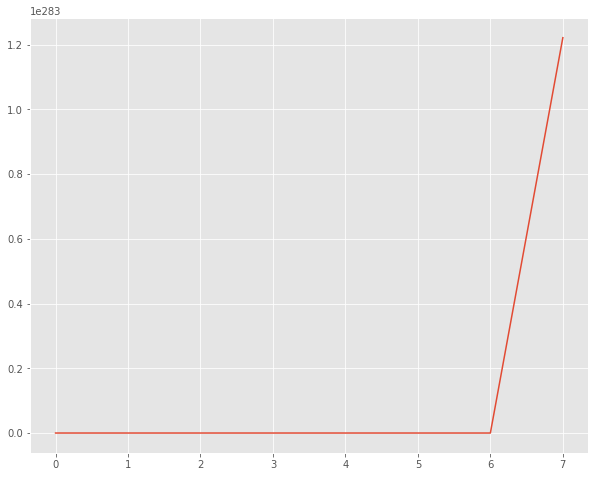

In [ ]:
regressor = LinearRegression()
np.random.seed(1)
dummy_X = np.random.randn(1000,5)
dummy_y = np.sum(dummy_X*3,axis=1, keepdims=True) + np.random.randn(1000,1)*0.5
stats = regressor.train(dummy_X,dummy_y,learning_rate=0.01,num_iters=500,batch_size=50,verbose=True)
plt.plot(stats['loss_history'])

**Sanity Check**: 

The loss plot should be exponentially decreasing and the loss values should be similar to the one below.

Expected output:
```
Epoch 0 	 training RMSE: 6.6090
Epoch 1 	 training RMSE: 5.3775
Epoch 2 	 training RMSE: 5.0075
Epoch 3 	 training RMSE: 3.7524
Epoch 4 	 training RMSE: 3.6866
iteration 100 / 500: loss 3.766868
Epoch 5 	 training RMSE: 2.2935
Epoch 6 	 training RMSE: 2.2515
Epoch 7 	 training RMSE: 1.7601
Epoch 8 	 training RMSE: 1.7724
Epoch 9 	 training RMSE: 1.9090
iteration 200 / 500: loss 1.001868
Epoch 10 	 training RMSE: 1.6331
Epoch 11 	 training RMSE: 1.1228
Epoch 12 	 training RMSE: 1.3707
Epoch 13 	 training RMSE: 1.0007
Epoch 14 	 training RMSE: 1.4122
iteration 300 / 500: loss 0.486848
Epoch 15 	 training RMSE: 1.0572
Epoch 16 	 training RMSE: 0.8985
Epoch 17 	 training RMSE: 0.7991
Epoch 18 	 training RMSE: 0.7868
Epoch 19 	 training RMSE: 0.7851
iteration 400 / 500: loss 0.236503
Epoch 20 	 training RMSE: 0.7128
Epoch 21 	 training RMSE: 0.7702
Epoch 22 	 training RMSE: 0.7366
Epoch 23 	 training RMSE: 0.7527
Epoch 24 	 training RMSE: 0.5996
iteration 500 / 500: loss 0.154280

```


### You have now successfully implemented Linear Regression using Stochastic Gradient Descent. Let's try it out on actual data.

Epoch 0 	 training RMSE: 108059882761985728.0000
Epoch 1 	 training RMSE: inf
Epoch 2 	 training RMSE: inf


/content/drive/My Drive/GRAD STUDIES/Term 1 AY 2020-2021/CSC713M Machine Learning/Notebooks/02 - Linear Regression/ME/LimI_linear_regression.py:133: RuntimeWarning: overflow encountered in square
  loss = np.sum(np.square((prediction - y)),axis=0)[0]


Epoch 3 	 training RMSE: inf
iteration 100 / 500: loss inf
Epoch 4 	 training RMSE: inf
Epoch 5 	 training RMSE: inf
Epoch 6 	 training RMSE: inf
iteration 200 / 500: loss inf
Epoch 7 	 training RMSE: inf
Epoch 8 	 training RMSE: inf
Epoch 9 	 training RMSE: inf
Epoch 10 	 training RMSE: inf
iteration 300 / 500: loss inf
Epoch 11 	 training RMSE: inf
Epoch 12 	 training RMSE: inf
Epoch 13 	 training RMSE: inf
iteration 400 / 500: loss inf
Epoch 14 	 training RMSE: inf
Epoch 15 	 training RMSE: inf
Epoch 16 	 training RMSE: inf
Epoch 17 	 training RMSE: inf
iteration 500 / 500: loss inf


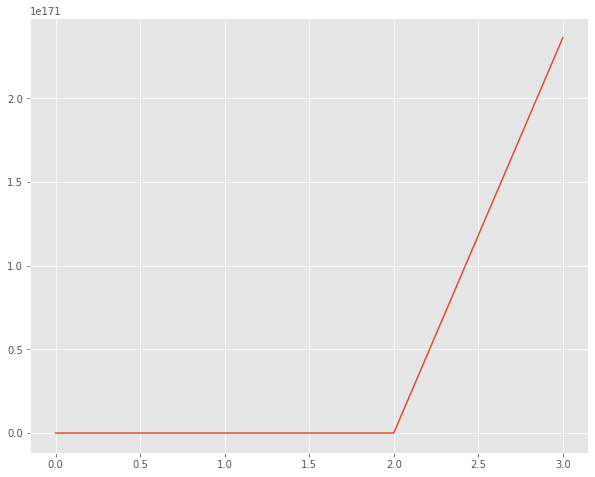

In [ ]:
np.random.seed(1)
regressor = LinearRegression()
stats = regressor.train(X_train,y_train,learning_rate=1e-4,num_iters=500,batch_size=512,verbose=True)
plt.plot(stats['loss_history'])

**Things not going as expected?** If the magnitude of the output and feature values are quite big, we can easily encounter numerical overflow (or underflow if the magnitude is too small). To address this issue, it is often a good idea to normalize or standardize the data.

### (Pre-processing) Standardize the features by subtracting it with its mean and then dividing by its standard deviation.

In [ ]:
################################################################################
# TODO:                                                                        #
# Standardize the training data and the validation data.                       #
################################################################################

X_train_norm = None
y_train_norm = None

X_val_norm = None
y_val_norm = None

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [ ]:
np.random.seed(1)
regressor = LinearRegression()
stats = regressor.train(X_train_norm,y_train_norm,X_val_norm, y_val_norm,
                            learning_rate=1e-2,learning_rate_decay=0.9,num_iters=1000,batch_size=512,verbose=True)

TypeError: ignored

**Sanity check**
```
Epoch 0 	 training RMSE: 0.9630
		 validation RMSE: 0.9605
Epoch 1 	 training RMSE: 0.8200
		 validation RMSE: 0.8651
Epoch 2 	 training RMSE: 0.8288
		 validation RMSE: 0.8060
Epoch 3 	 training RMSE: 1.0526
		 validation RMSE: 0.7706
iteration 100 / 1000: loss 0.319256
Epoch 4 	 training RMSE: 0.7171
		 validation RMSE: 0.7453
Epoch 5 	 training RMSE: 0.8004
		 validation RMSE: 0.7308
Epoch 6 	 training RMSE: 0.7045
		 validation RMSE: 0.7204
iteration 200 / 1000: loss 0.354085
Epoch 7 	 training RMSE: 0.7163
		 validation RMSE: 0.7136
Epoch 8 	 training RMSE: 0.8864
		 validation RMSE: 0.7091
Epoch 9 	 training RMSE: 0.7350
		 validation RMSE: 0.7050
Epoch 10 	 training RMSE: 0.7186
		 validation RMSE: 0.7037
iteration 300 / 1000: loss 0.195399
Epoch 11 	 training RMSE: 0.6950
		 validation RMSE: 0.7017
Epoch 12 	 training RMSE: 0.7377
		 validation RMSE: 0.7007
Epoch 13 	 training RMSE: 0.7426
		 validation RMSE: 0.6996
iteration 400 / 1000: loss 0.275122
Epoch 14 	 training RMSE: 0.8269
		 validation RMSE: 0.6986
Epoch 15 	 training RMSE: 0.6815
		 validation RMSE: 0.6979
Epoch 16 	 training RMSE: 0.6626
		 validation RMSE: 0.6973
Epoch 17 	 training RMSE: 0.8149
		 validation RMSE: 0.6969
iteration 500 / 1000: loss 0.284460
Epoch 18 	 training RMSE: 0.7000
		 validation RMSE: 0.6966
Epoch 19 	 training RMSE: 0.8664
		 validation RMSE: 0.6963
Epoch 20 	 training RMSE: 0.6585
		 validation RMSE: 0.6961
iteration 600 / 1000: loss 0.219908
Epoch 21 	 training RMSE: 0.6556
		 validation RMSE: 0.6960
Epoch 22 	 training RMSE: 0.6476
		 validation RMSE: 0.6958
Epoch 23 	 training RMSE: 0.6376
		 validation RMSE: 0.6957
Epoch 24 	 training RMSE: 0.8272
		 validation RMSE: 0.6956
iteration 700 / 1000: loss 0.179505
Epoch 25 	 training RMSE: 0.7812
		 validation RMSE: 0.6955
Epoch 26 	 training RMSE: 0.7189
		 validation RMSE: 0.6954
Epoch 27 	 training RMSE: 0.6691
		 validation RMSE: 0.6953
iteration 800 / 1000: loss 0.233584
Epoch 28 	 training RMSE: 0.8886
		 validation RMSE: 0.6952
Epoch 29 	 training RMSE: 0.6723
		 validation RMSE: 0.6952
Epoch 30 	 training RMSE: 0.7169
		 validation RMSE: 0.6951
iteration 900 / 1000: loss 0.352268
Epoch 31 	 training RMSE: 0.8394
		 validation RMSE: 0.6951
Epoch 32 	 training RMSE: 0.6996
		 validation RMSE: 0.6951
Epoch 33 	 training RMSE: 0.7227
		 validation RMSE: 0.6950
Epoch 34 	 training RMSE: 0.6987
		 validation RMSE: 0.6950
iteration 1000 / 1000: loss 0.371101
```

Are your results slightly different? You might want to consider checking your code again. 

**Hint**: it may have to do with how you treat your data before predicting.

It is useful to keep track of the losses as well as both the training set performance and the validation set performance while training so we can get some insights as to how the learning process is going. We will be discussing more on error analysis later on in the course. Let's visualize the loss history as well as the RMSE history of the training set and validation set during training process. 

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
tr = plt.plot(stats['train_rmse'], label='train')
vl = plt.plot(stats['val_rmse'], label='val')
plt.title('Root Mean Squared Error history')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(('val','train'))
plt.show()

All of them seem to be converging, which is usually a good sign.

Now that we have trained our model, we need to convert the predicted values back to its original scale.

In [ ]:
# plot fitted regression line 
X_range = np.expand_dims(np.arange(0,5000,1),1)
################################################################################
# TODO:                                                                        #
# Standardize the data.                                                        #
################################################################################
X_range_norm = None

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

y_range_norm = regressor.predict(X_range_norm)

################################################################################
# TODO:                                                                        #
# Convert the predicted y values back to its original scale.                   #
################################################################################
y_range = None
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
plt.scatter(X_train,y_train,c='green')
plt.plot(X_range,y_range,c='blue')
plt.xlim([0,5000])
plt.ylim([0,1500000])
plt.ylabel("Price")
plt.xlabel("Living area")

### We can now try the model on the separate test set in order to fairly evaluate its performance.

In [ ]:
# plot fitted regression line 

################################################################################
# TODO:                                                                        #
# Standardize the your training and validation data by subtracting it with     #
# its mean and then dividing by its standard deviation.                        #
################################################################################
X_test_norm = None
y_test_norm = None
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

y_test_norm_pred = regressor.predict(X_test_norm)

################################################################################
# TODO:                                                                        #
# Convert the predicted y values back to its original scale.                   #
################################################################################
y_test_pred = None
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################



plt.scatter(X_test,y_test,c='green')
plt.plot(X_test,y_test_pred,c='blue')
plt.xlim([0,5000])
plt.ylim([0,1500000])
plt.ylabel("Price")
plt.xlabel("Living area")

In [ ]:
RMSE = np.sqrt(np.mean((y_test_norm_pred - y_test_norm)**2))
print("Test set RMSE:",RMSE)

### How does the learning rate affect the training?
In practice, we do not know the optimal learning rate in advanced. One way to search for a good learning rate is to try different values of it.

In [ ]:
np.random.seed(1)
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
plt_ctr = 1
plt.figure(figsize=(15,10))
for alpha in alphas:
    regressor = LinearRegression()
    stats = regressor.train(X_train_norm,y_train_norm,X_val_norm, y_val_norm,
                                learning_rate=alpha,learning_rate_decay=0.9,num_iters=1000,batch_size=512,verbose=False)
    plt.subplot(2,3,plt_ctr)
    plt.plot(stats['loss_history'])
    plt.title('Loss history (alpha = '+str(alpha)+')')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt_ctr+=1

Looking at the shape of the loss plot the optimal learning rate would be near 0.01. Later on in the course we will be discussing how to efficiently tune hyperparameters such as the learning rate.

## Experiment!
We have only used one feature so far. Try out other feature combinations to improve the model's performance. Feel free to try out other things as well. :)

## <center> fin </center>


<sup>made/compiled by daniel stanley tan & courtney anne ngo 🐰 & thomas james tiam-lee</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> danieltan07@gmail.com & courtneyngo@gmail.com & thomasjamestiamlee@gmail.com</sup><br>
<sup>please cc your instructor, too</sup>
<!-- DO NOT MODIFY OR DELETE THIS -->
